In [1]:
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

In [4]:
# Please use the class protein_aliter for more functionality

"""
class protein:
    def __init__(self, scale=10.0):
        self.scale = float(scale)
        self.ground_state = [[np.array([[0.0, 0.0, 0.0], [self.scale, 0.0, 0.0],\
                            [np.random.uniform(high=self.scale), np.random.uniform(low=self.scale/2, high=2*self.scale), 0.0]]), np.random.choice(2, 1)]]
        self.cryoem_imgs = []
        self.gaussian_atoms = []

    def create_ground_state(self, num=1):
        for iter in range(num-1):
            last_triangle = self.ground_state[-1]
            [a, b] = [last_triangle[0][1, 0:2], last_triangle[0][2, 0:2]] if int(last_triangle[1]) == 0\
                 else [last_triangle[0][2, 0:2], last_triangle[0][0, 0:2]]

            theta = np.random.uniform(low=np.pi/4, high=np.pi/2) 
            rot = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
            c = b + np.dot(rot, a - b) * np.random.uniform(low=self.scale/2, high=2*self.scale)/np.linalg.norm(a - b)
            d = last_triangle[0][int(last_triangle[1]), 0:2]

            old = np.hstack(([a,b,c], [[1.0], [1.0], [1.0]]))
            new = np.hstack(([a,b,d], [[1.0], [1.0], [1.0]]))

            #if ((a[1] - b[1])*(c[0] - a[0]) + (b[0] - a[1])*(c[1] - a[1]))*((a[1] - b[1])*(d[0] - a[0]) + (b[0] - a[1])*(d[1] - a[1])) > 0:
            if np.linalg.det(old) * np.linalg.det(new) > 0:
                #print(f"{np.rad2deg(theta)}: Same side, since c={c}, d={d}")
                theta = -theta
                rot = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
                c = b + np.dot(rot, a - b) * np.random.uniform(low=self.scale/2, high=2*self.scale)/np.linalg.norm(a - b)

            new_triangle = [np.array([np.append(a, 0.0), np.append(b, 0.0), np.append(c, 0.0)]), np.random.choice(2, 1)]
            self.ground_state.append(new_triangle)

    def create_cryoem_imgs(self, num=1):
        for n in range(num):
            new_state = []
            for triangle in self.ground_state:
                new_state.append([triangle[0]*1.0, triangle[1]])
                #new_state[-1][0] *= 5

                [a, b] = [new_state[-1][0][1], new_state[-1][0][2]] if int(new_state[-1][1]) == 0\
                 else [new_state[-1][0][2], new_state[-1][0][0]]
                r = R.from_rotvec(np.random.uniform(low=-np.pi/3, high=np.pi/3) * (a - b)/np.linalg.norm(a - b))

                for tri in new_state:
                    for i in [0,1,2]:
                       tri[0][i] = b + r.apply(tri[0][i] - b)

            self.cryoem_imgs.append(new_state)


    def create_gaussian_atoms(self):
        pass

    def print(self):
        print(self.ground_state)

    def plot2d(self, option="ground"):
        if option == "ground":
            for triangle in self.ground_state:
                triangle_x = triangle[0][:,0]
                triangle_x = np.append(triangle_x, triangle_x[0])
                triangle_y = triangle[0][:,1]
                triangle_y = np.append(triangle_y, triangle_y[0])

                plt.plot(triangle_x, triangle_y)
            
            #plt.xlim([-15, 15])
            #plt.ylim([-15, 15])
            plt.show()
        else:
            for image in self.cryoem_imgs:
                for triangle in image:
                    triangle_x = triangle[0][:,0]
                    triangle_x = np.append(triangle_x, triangle_x[0])
                    triangle_y = triangle[0][:,1]
                    triangle_y = np.append(triangle_y, triangle_y[0])

                    plt.plot(triangle_x, triangle_y)
            
                #plt.xlim([-15, 15])
                #plt.ylim([-15, 15])
                plt.show()
                """

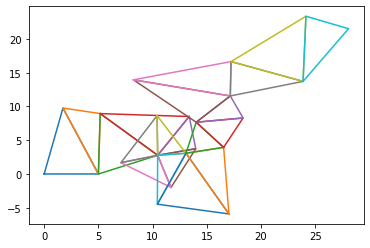

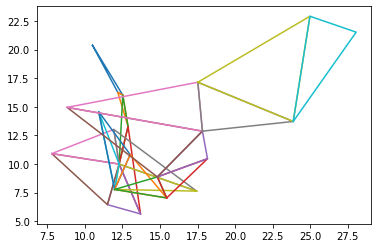

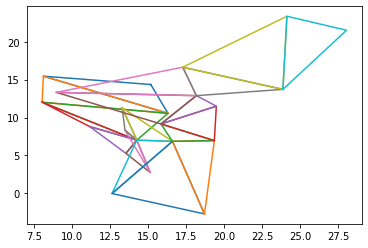

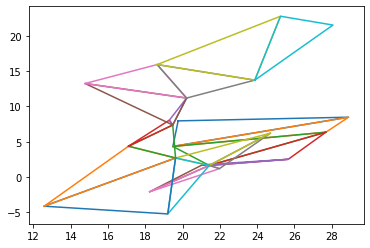

In [55]:
protein1 = protein(scale = 5)
protein1.create_ground_state(num=20)
protein1.plot2d(option="ground")
protein1.create_cryoem_imgs(num=3)
protein1.plot2d(option="cryoem")

# Generate protein images

In [56]:
class protein_aliter:
    def __init__(self, scale=10.0, centering=True):
        self.scale = float(scale)
        self.centering = centering
        self.ground_state = [np.array([[0.0, 0.0, 0.0], [self.scale, 0.0, 0.0],\
                            [np.random.uniform(high=self.scale), np.random.uniform(low=self.scale/2, high=2*self.scale), 0.0]])]
        self.notfree = np.random.choice(2, 1)
        self.cryoem_imgs = []
        self.rotations = []
        self.gaussian_atoms = []


    def create_ground_state(self, num=1):
        for iter in range(num-1):
            # Create sides a, b, c for new triangle to add in ground state
            [a, b] = [self.ground_state[-1][1, 0:2], self.ground_state[-1][2, 0:2]] if self.notfree[-1] == 0\
                 else [self.ground_state[-1][2, 0:2], self.ground_state[-1][0, 0:2]]

            theta = np.random.uniform(low=np.pi/4, high=np.pi/2) 
            rot = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
            c = b + np.dot(rot, a - b) * np.random.uniform(low=self.scale/2, high=2*self.scale)/np.linalg.norm(a - b)
            d = self.ground_state[-1][self.notfree[-1], 0:2]

            old = np.hstack(([a,b,c], [[1.0], [1.0], [1.0]]))
            new = np.hstack(([a,b,d], [[1.0], [1.0], [1.0]]))

            # Make sure the new vertex and opposite vertex of adjacent triangle lie on different sides
            if np.linalg.det(old) * np.linalg.det(new) > 0:
                theta = -theta
                rot = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
                c = b + np.dot(rot, a - b) * np.random.uniform(low=self.scale/2, high=2*self.scale)/np.linalg.norm(a - b)

            self.ground_state.append(np.hstack(([a,b,c], [[0.0], [0.0], [0.0]])))
            self.notfree = np.append(self.notfree, np.random.choice(2, 1))

        # Centering
        if self.centering:
            mean_centre = np.mean(self.ground_state, axis=(0, 1))
            self.ground_state = [triangle - mean_centre for triangle in self.ground_state]


    def create_cryoem_imgs(self, num=1):
        for n in range(num):
            new_state = []

            # Creating new state (conformation) by rotating ground state triangles
            for triangle, side in zip(self.ground_state, self.notfree):
                new_state.append(triangle*1.0)

                [a, b] = [new_state[-1][1], new_state[-1][2]] if side == 0 else [new_state[-1][2], new_state[-1][0]]
                r = R.from_rotvec(np.random.uniform(low=-np.pi/3, high=np.pi/3) * (a - b)/np.linalg.norm(a - b))

                for tri in new_state:
                    for i in [0,1,2]:
                       tri[i] = b + r.apply(tri[i] - b)

            # Centering
            if self.centering:
                mean_centre = np.mean(new_state, axis=(0, 1))
                new_state = [triangle - mean_centre for triangle in new_state]

            # Rotation by random euler angles
            angles = np.pi * np.array([2,1,2]) * np.random.uniform(size=3)
            self.rotations.append(angles)
            r = R.from_euler('zyz', angles)

            for tri in new_state:
                for i in [0,1,2]:
                    tri[i] = r.apply(tri[i])

            # Appending this new state in list of cryoem images
            self.cryoem_imgs.append(new_state)


    def create_gaussian_atoms(self):
        pass


    def get_info(self, option="ground"):
        return self.ground_state, self.notfree, self.create_cryoem_imgs, self.rotations, self.gaussian_atoms


    def plot2d(self, ground=False):
        if ground:
            for triangle in self.ground_state:
                triangle_x = triangle[:,0]
                triangle_x = np.append(triangle_x, triangle_x[0])
                triangle_y = triangle[:,1]
                triangle_y = np.append(triangle_y, triangle_y[0])

                plt.plot(triangle_x, triangle_y)
            
            #plt.xlim([-15, 15])
            #plt.ylim([-15, 15])
            plt.show()
        else:
            for image in self.cryoem_imgs:
                for triangle in image:
                    triangle_x = triangle[:,0]
                    triangle_x = np.append(triangle_x, triangle_x[0])
                    triangle_y = triangle[:,1]
                    triangle_y = np.append(triangle_y, triangle_y[0])

                    plt.plot(triangle_x, triangle_y)
            
                plt.show()

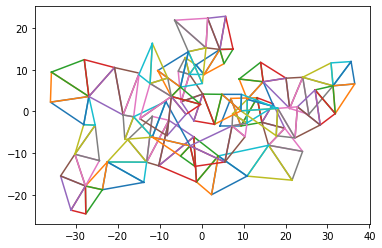

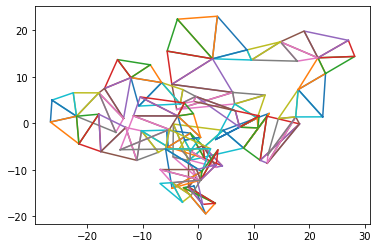

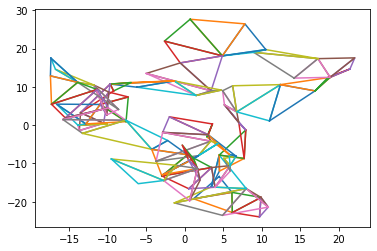

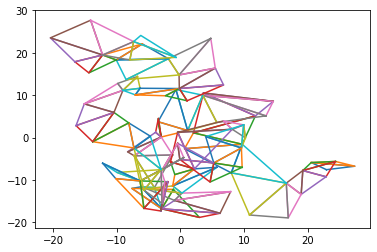

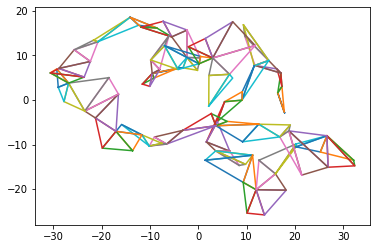

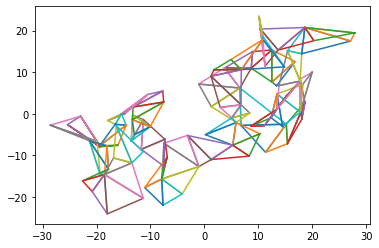

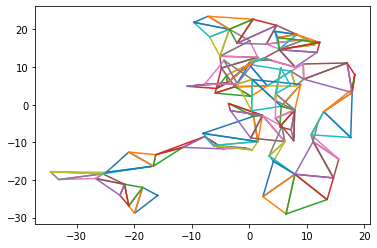

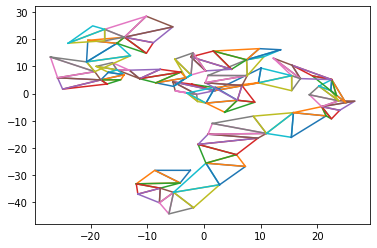

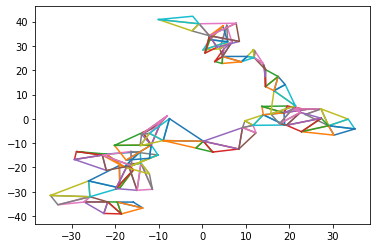

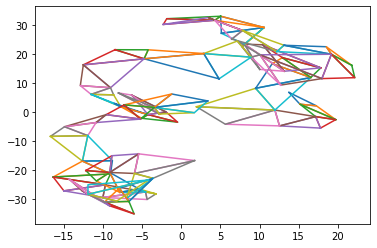

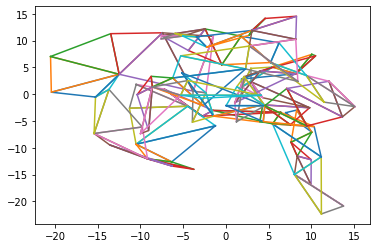

In [66]:
protein2 = protein_aliter(scale = 5)
protein2.create_ground_state(num=100)
protein2.plot2d(ground = True)
protein2.create_cryoem_imgs(num=10)
protein2.plot2d(ground = False)